In [4]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np


In [5]:
df= pd.read_csv('Financial-Campaign-full.csv')#loads the csv file into a pandas dataframe
df.head()

,Age,Job,Marital,Education,Credit?,Balance,HousingLoan,PersonalLoan,Contact,LastDay,LastMonth,ContactDuration,CampaignContacts,Pdays,PreviousContacts,POutcome,Coutcome
0,34,blue-collar,married,secondary,no,7216,yes,no,unknown,26,may,143,2,-1,0,unknown,no
1,29,housemaid,married,secondary,no,823,yes,no,unknown,23,may,14,2,-1,0,unknown,no
2,41,blue-collar,married,primary,no,17,no,no,cellular,8,jul,117,3,-1,0,unknown,no
3,37,technician,married,secondary,no,729,yes,no,cellular,15,jul,115,5,-1,0,unknown,no
4,32,blue-collar,single,secondary,no,15341,no,no,unknown,21,may,738,3,-1,0,unknown,no


# Data Exploration

In [5]:
df.shape # 45000 rows 17 cols, lots of data!


(45208, 17)

There are 10 non numeric columns that we need to consider if we want to include that in our analysis because we will need to convert them to numeric values for clustering purposes.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45208 entries, 0 to 45207
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               45208 non-null  int64 
 1   Job               45208 non-null  object
 2   Marital           45208 non-null  object
 3   Education         45208 non-null  object
 4   Credit?           45208 non-null  object
 5   Balance           45208 non-null  int64 
 6   HousingLoan       45208 non-null  object
 7   PersonalLoan      45208 non-null  object
 8   Contact           45208 non-null  object
 9   LastDay           45208 non-null  int64 
 10  LastMonth         45208 non-null  object
 11  ContactDuration   45208 non-null  int64 
 12  CampaignContacts  45208 non-null  int64 
 13  Pdays             45208 non-null  int64 
 14  PreviousContacts  45208 non-null  int64 
 15  POutcome          45208 non-null  object
 16  Coutcome          45208 non-null  object
dtypes: int64(7),

In [7]:
df.dtypes # lots of numbers and strings

Age                  int64
Job                 object
Marital             object
Education           object
Credit?             object
Balance              int64
HousingLoan         object
PersonalLoan        object
Contact             object
LastDay              int64
LastMonth           object
ContactDuration      int64
CampaignContacts     int64
Pdays                int64
PreviousContacts     int64
POutcome            object
Coutcome            object
dtype: object

In [8]:
df.Age.describe()

count    45208.000000
mean        40.935166
std         10.618272
min         18.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         95.000000
Name: Age, dtype: float64

Avg age is 40.9, medium age is 39, oldest is 95, youngest is 18.

This tells us here are alot of middle aged people starting from 30 to 60

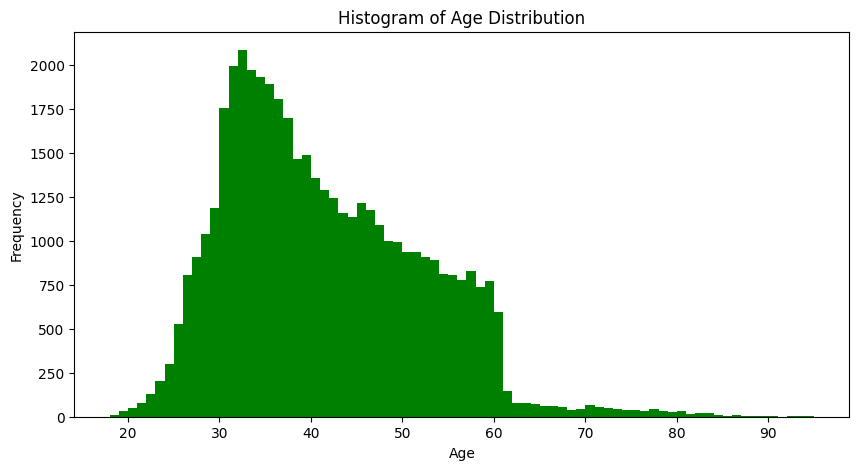

In [9]:
# Age stuff
plt.figure(figsize=(10, 5))
plt.hist(df['Age'].values, rwidth=1, bins =77, color='green')
plt.title('Histogram of Age Distribution')
plt.ylabel('Frequency')
plt.xlabel('Age')
plt.show()

The below code is creating a pie chart for all individuals that have above average balances based on their marital status. Throughout our analysis we have also noticed about 26% of all individuals are above the mean (average) balance. We are inferring that the financial institutions marketing campaign for higher balance individuals will only affect 26% of their customers.

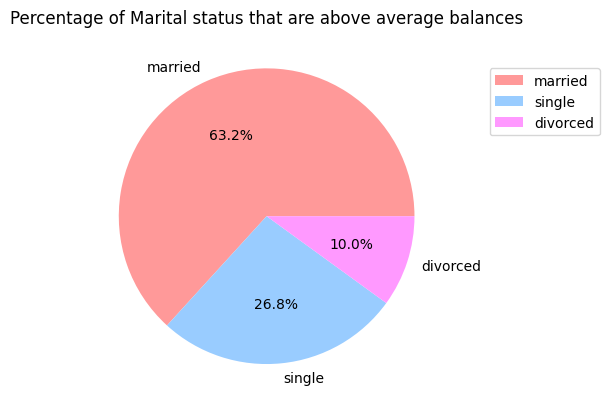

In [10]:
average_balance = df['Balance'].mean()

above_average_bal = len(df[df['Balance'] > average_balance]) #number of people that have above average balances
#df.describe()

marital_titles = df['Marital'].value_counts().index.to_list()


marital_above_average_bal = []
status_total = 0
marital_percentage_above_average_bal = []


for m in marital_titles:
    status_total = df[df['Marital'] == m]
    marital_above_average_bal.append(len(status_total[status_total['Balance'] > average_balance]))

total_count = sum(marital_above_average_bal)
for marital in marital_above_average_bal:
    marital_percentage_above_average_bal.append(marital / total_count * 100)

bar_colors = ['#FF9999', '#99CCFF', '#FF99FF']

plt.pie(marital_percentage_above_average_bal,  colors=bar_colors, labels=marital_titles,autopct='%1.1f%%')

plt.title('Percentage of Marital status that are above average balances')
plt.legend(loc="lower right", bbox_to_anchor=(1.42,0.7))

plt.show()


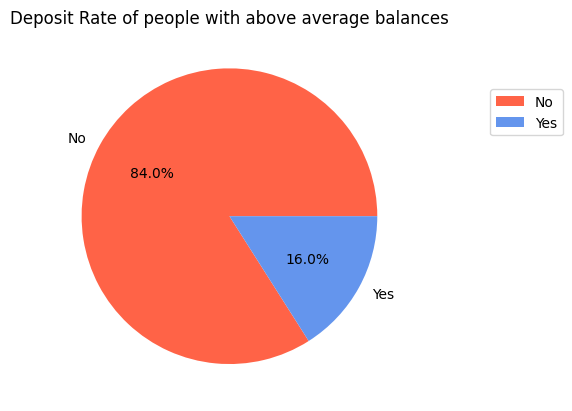

[84.00442666212649, 15.9955733378735]


In [11]:
#people with above average balances
average_balance = df['Balance'].mean()

above_average_bal = df[df['Balance'] > average_balance]

# number of people that put down a term deposit vs people that did not put down a term deposit
NoDeposit = len(above_average_bal[above_average_bal["Coutcome"] =='no'])
YesDeposit = len(above_average_bal[above_average_bal["Coutcome"] =='yes'])

#print(NoDeposit)
#print(YesDeposit)




total_cooutcome = []
total_cooutcome.append(NoDeposit/len(above_average_bal) * 100)
total_cooutcome.append(YesDeposit/len(above_average_bal) * 100)
#plt.bar(above_average_bal['Coutcome'].unique(), above_average_bal["Coutcome"].value_counts(), color=bar_colors, align='center', width=0.5) =
plt.pie(total_cooutcome,  colors=[ 'tomato', 'cornflowerblue'], labels=['No', 'Yes'], autopct='%1.1f%%')


plt.legend(loc="lower right", bbox_to_anchor=(1.42,0.7))
plt.title('Deposit Rate of people with above average balances')

plt.show()
print(total_cooutcome)

<h1> Percentage of Individuals are above the mean (average) balance <h1>

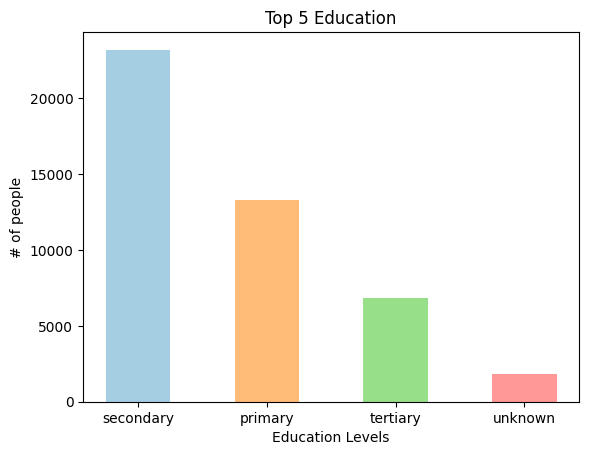

In [12]:
bar_colors = ['#a6cee3', '#ffbb78', '#98df8a', '#ff9896', '#cfa3e3']

plt.bar(df['Education'].unique(), df["Education"].value_counts(), color=bar_colors, align='center', width=0.5)

plt.ylabel('# of people')
plt.xlabel('Education Levels')
plt.title('Top 5 Education')

plt.show()

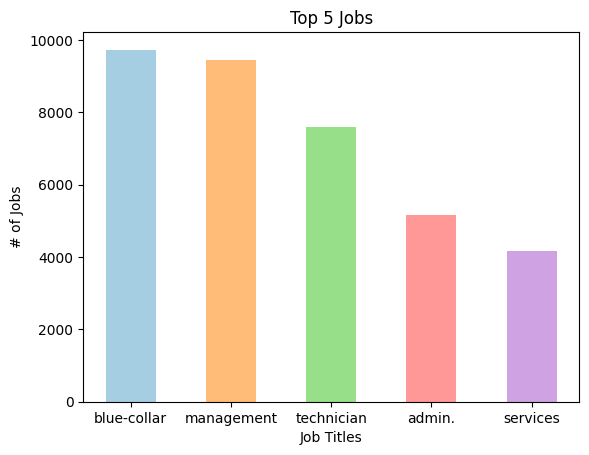

In [13]:
job_title = df['Job'].value_counts()[:5].index.to_list()

job_counts = df['Job'].value_counts()[:5]

# Convert the value counts to a NumPy array
job_counts_array = job_counts.values

#job_title = ['Blue Collar', 'House Maid', 'Technician', 'Management', 'Entrepreneur']

bar_colors = ['#a6cee3', '#ffbb78', '#98df8a', '#ff9896', '#cfa3e3']

plt.bar(job_title, job_counts, color=bar_colors, label=job_title, align='center', width=0.5)

plt.ylabel('# of Jobs')
plt.xlabel('Job Titles')
plt.title('Top 5 Jobs')
#plt.legend(title='Fruit color')

plt.show()



In [59]:
# this is just crude numberization so i can visualize the data
corr_df = pd.read_csv('Financial-Campaign-full.csv')
corr_df.replace(['yes', 'no'],[1, 0], inplace=True)

C:\Users\yasee\AppData\Local\Temp\ipykernel_14880\1166312440.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_df.replace(['yes', 'no'],[1, 0], inplace=True)


In [60]:
corr_df.corr(numeric_only=True)

,Age,Credit?,Balance,HousingLoan,PersonalLoan,LastDay,ContactDuration,CampaignContacts,Pdays,PreviousContacts,Coutcome
Age,1.000000,-0.017867,0.097810,-0.185584,-0.015614,-0.011131,-0.004661,0.004772,-0.023720,0.001313,0.025193
Credit?,-0.017867,1.000000,-0.066747,-0.006023,0.077231,0.008700,-0.010022,0.016820,-0.029983,-0.018332,-0.022422
Balance,0.097810,-0.066747,1.000000,-0.068775,-0.084358,0.003683,0.021564,-0.014582,0.003429,0.016670,0.052833
HousingLoan,-0.185584,-0.006023,-0.068775,1.000000,0.041331,-0.025065,0.005040,-0.023602,0.124189,0.037081,-0.139172
PersonalLoan,-0.015614,0.077231,-0.084358,0.041331,1.000000,0.010082,-0.012414,0.009976,-0.022766,-0.011051,-0.068196
LastDay,-0.011131,0.008700,0.003683,-0.025065,0.010082,1.000000,-0.029757,0.152705,-0.088560,-0.049254,-0.027345
ContactDuration,-0.004661,-0.010022,0.021564,0.005040,-0.012414,-0.029757,1.000000,-0.084568,-0.001566,0.001202,0.394536
CampaignContacts,0.004772,0.016820,-0.014582,-0.023602,0.009976,0.152705,-0.084568,1.000000,-0.088632,-0.032858,-0.073176
Pdays,-0.023720,-0.029983,0.003429,0.124189,-0.022766,-0.088560,-0.001566,-0.088632,1.000000,0.454816,0.103613
PreviousContacts,0.001313,-0.018332,0.016670,0.037081,-0.011051,-0.049254,0.001202,-0.032858,0.454816,1.000000,0.093230


## Some things we noticed from this correlation chart

Higher age = more likely married, but lower education

people withe cell phones where more likely to have been contacted in prev campaine

higher last contract duration = more likely to have subscribed to term deposit (Coutcome)

People contacted in prev campaine (non -1 pdays) = more likely to have subscribed to term deposit (Coutcome)

The more someone was contacted before the campaine = less likely to have a sucess rating in Poitcome, but more likely to have subscribed to term deposit (Coutcome)

# Data Cleaning

In [6]:
clean_df = df

<h1>Missing values<h1>

The first step of data cleaning would be to see if there is any values that are null, as you can see there is no null values

In [7]:
 #returns the number of missing values
clean_df.isnull().sum()

Age                 0
Job                 0
Marital             0
Education           0
Credit?             0
Balance             0
HousingLoan         0
PersonalLoan        0
Contact             0
LastDay             0
LastMonth           0
ContactDuration     0
CampaignContacts    0
Pdays               0
PreviousContacts    0
POutcome            0
Coutcome            0
dtype: int64

The second step of data cleaning would be to see if there are any values that are empty

In [8]:
 #returns the number of missing values
clean_df.isna().sum()

Age                 0
Job                 0
Marital             0
Education           0
Credit?             0
Balance             0
HousingLoan         0
PersonalLoan        0
Contact             0
LastDay             0
LastMonth           0
ContactDuration     0
CampaignContacts    0
Pdays               0
PreviousContacts    0
POutcome            0
Coutcome            0
dtype: int64

<h1>Find all the Job names<h1>

As you can see for Admin role there is an extra period added to the end of the data which we will remove the period from the dataset  

In [19]:
clean_df['Job'].unique()

array(['blue-collar', 'housemaid', 'technician', 'management',
       'entrepreneur', 'admin.', 'services', 'self-employed', 'retired',
       'unemployed', 'unknown', 'student'], dtype=object)

<h1>Find all the month names<h1>

As you can see for lastMonth column there is incorrectly typed Month of may which includes two Y's, we will replace the existing value back to correct format


In [20]:
#Find all the unique month columns
clean_df['LastMonth'].unique()

array(['may', 'jul', 'jun', 'mayY', 'aug', 'oct', 'nov', 'dec', 'jan',
       'feb', 'mar', 'apr', 'sep'], dtype=object)

Entry #13 has an error month is labeled as mayY (drop this record or replace)
jobs has unknown

In [9]:
# We will replace the mayY with may

clean_df['LastMonth'].replace('mayY', 'may', inplace=True)

#We will replace the admin. with admin
clean_df['Job'].replace('admin.', 'admin', inplace=True)


C:\Users\yasee\AppData\Local\Temp\ipykernel_14880\2711531822.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  clean_df['LastMonth'].replace('mayY', 'may', inplace=True)
C:\Users\yasee\AppData\Local\Temp\ipykernel_14880\2711531822.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

Verifying that month and job columns have clean data

In [10]:
clean_df[(clean_df['LastMonth'] == 'mayY')]

,Age,Job,Marital,Education,Credit?,Balance,HousingLoan,PersonalLoan,Contact,LastDay,LastMonth,ContactDuration,CampaignContacts,Pdays,PreviousContacts,POutcome,Coutcome


In [11]:
clean_df[(clean_df['Job'] == 'admin.')]

,Age,Job,Marital,Education,Credit?,Balance,HousingLoan,PersonalLoan,Contact,LastDay,LastMonth,ContactDuration,CampaignContacts,Pdays,PreviousContacts,POutcome,Coutcome


jobs, Education, Contact(this one may not be issue), POutcome has unknons
Last month has a mayY value
Pdays has a -1 value may not be issue
LastDay has 1 value above 600

<h1>Dropping the LastDay column <h1>

In our findings we found that there was one outlier which had value of 628 which doesn't make sense for LastDay communciated by the financial institute. We also decided that we aren't going to be use the LastDay column in our clustering process so we will drop this column completely

In [12]:
clean_df[(clean_df['LastDay'] == 628)]

,Age,Job,Marital,Education,Credit?,Balance,HousingLoan,PersonalLoan,Contact,LastDay,LastMonth,ContactDuration,CampaignContacts,Pdays,PreviousContacts,POutcome,Coutcome
605,23,blue-collar,single,secondary,no,214,yes,no,unknown,628,may,44,1,-1,0,unknown,no


In [13]:
clean_df = clean_df.drop(columns=['LastDay'])
clean_df = clean_df.drop(columns=['Contact'])
clean_df = clean_df.drop(columns=['POutcome'])

In [14]:
clean_df = clean_df.drop(clean_df[(clean_df['Job'] == 'unknown')].index)

clean_df[(clean_df['Job'] == 'unknown')]

clean_df['Job'].unique()


array(['blue-collar', 'housemaid', 'technician', 'management',
       'entrepreneur', 'admin', 'services', 'self-employed', 'retired',
       'unemployed', 'student'], dtype=object)

In [15]:
clean_df = clean_df.drop(clean_df[(clean_df['Education'] == 'unknown')].index)

clean_df['Education'].unique()

array(['secondary', 'primary', 'tertiary'], dtype=object)

In [16]:
clean_df.replace(['yes', 'no'],[1, 0], inplace=True)

C:\Users\yasee\AppData\Local\Temp\ipykernel_14880\4245664739.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clean_df.replace(['yes', 'no'],[1, 0], inplace=True)


In [17]:
display(clean_df)

,Age,Job,Marital,Education,Credit?,Balance,HousingLoan,PersonalLoan,LastMonth,ContactDuration,CampaignContacts,Pdays,PreviousContacts,Coutcome
0,34,blue-collar,married,secondary,0,7216,1,0,may,143,2,-1,0,0
1,29,housemaid,married,secondary,0,823,1,0,may,14,2,-1,0,0
2,41,blue-collar,married,primary,0,17,0,0,jul,117,3,-1,0,0
3,37,technician,married,secondary,0,729,1,0,jul,115,5,-1,0,0
4,32,blue-collar,single,secondary,0,15341,0,0,may,738,3,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45203,51,technician,married,tertiary,0,825,0,0,nov,977,3,-1,0,1
45204,71,retired,divorced,primary,0,1729,0,0,nov,456,2,-1,0,1
45205,72,retired,married,secondary,0,5715,0,0,nov,1127,5,184,3,1
45206,57,blue-collar,married,secondary,0,668,0,0,nov,508,4,-1,0,0


Clustering Ideas

best month for marketting campaign

avg # contacts per month

new vs old people Coutcome



This financial institution is very new considering the number of new

In [18]:
#df['POutcome'].value_counts()

#df[(df['Pdays'] == -1)]['POutcome'].value_counts()]

#36951
#failure     4901


# New marketing campaign reached a broader audience but overal the percenetage of success was very low
#df[(df['Pdays'] == -1)]["Coutcome"].value_counts()

# Old
current_customers = clean_df[(clean_df['Pdays'] != -1)].value_counts().reset_index()
current_customers
#df[(df['Pdays'] == -1)][['Pdays', 'POutcome']].value_counts()

,Age,Job,Marital,Education,Credit?,Balance,HousingLoan,PersonalLoan,LastMonth,ContactDuration,CampaignContacts,Pdays,PreviousContacts,Coutcome,count
0,18,student,single,primary,0,608,0,0,nov,210,1,93,1,1,1
1,44,blue-collar,married,tertiary,0,1371,0,0,may,788,3,363,4,0,1
2,44,blue-collar,married,secondary,0,3060,1,0,nov,113,1,189,2,0,1
3,44,blue-collar,married,secondary,0,3060,1,0,apr,87,2,151,3,0,1
4,44,blue-collar,married,secondary,0,2979,1,0,may,18,5,178,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7907,34,management,single,tertiary,0,-444,1,1,apr,129,2,148,4,0,1
7908,34,management,married,tertiary,0,8000,0,0,feb,291,1,260,2,1,1
7909,34,management,married,tertiary,0,5878,0,0,jan,159,7,98,3,0,1
7910,34,management,married,tertiary,0,4859,0,0,aug,262,2,112,2,0,1


<h1>Selection and Clustering<h1>

In [19]:
#categorical_cols = ['City','Gender']

jobs = clean_df['Job']

categorical_cols = ['Job','LastMonth','Marital']
# loc is a indexer to select all rows (:) , X_cat will be a 2D NumPy array containing the values from the 'LastMonth' columns of df.
X_cat = clean_df.loc[:,categorical_cols].values
data_other_cols = clean_df.drop(columns=categorical_cols)

#print(X_cat)
#print(X_cat.shape)

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_cat)
feature_names = enc.get_feature_names_out(categorical_cols)
print(feature_names)
X_cat_new = enc.transform(X_cat)
print(X_cat_new.shape)

['Job_admin' 'Job_blue-collar' 'Job_entrepreneur' 'Job_housemaid'
 'Job_management' 'Job_retired' 'Job_self-employed' 'Job_services'
 'Job_student' 'Job_technician' 'Job_unemployed' 'LastMonth_apr'
 'LastMonth_aug' 'LastMonth_dec' 'LastMonth_feb' 'LastMonth_jan'
 'LastMonth_jul' 'LastMonth_jun' 'LastMonth_mar' 'LastMonth_may'
 'LastMonth_nov' 'LastMonth_oct' 'LastMonth_sep' 'Marital_divorced'
 'Marital_married' 'Marital_single']
(43190, 26)


In [20]:
data_hot_encoded = pd.DataFrame(X_cat_new.toarray(),index=clean_df.index,columns=feature_names)
data_hot_encoded.to_csv('new_Data.csv',sep=',')

data_hot_encoded.head()




,Job_admin,Job_blue-collar,Job_entrepreneur,Job_housemaid,Job_management,Job_retired,Job_self-employed,Job_services,Job_student,Job_technician,...,LastMonth_jul,LastMonth_jun,LastMonth_mar,LastMonth_may,LastMonth_nov,LastMonth_oct,LastMonth_sep,Marital_divorced,Marital_married,Marital_single
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [21]:
new_df = pd.concat([data_other_cols,data_hot_encoded],axis =1)

new_df.to_csv('new_Data.csv',sep=',')

new_df.columns.tolist()


clean_df = new_df

clean_df


,Age,Education,Credit?,Balance,HousingLoan,PersonalLoan,ContactDuration,CampaignContacts,Pdays,PreviousContacts,...,LastMonth_jul,LastMonth_jun,LastMonth_mar,LastMonth_may,LastMonth_nov,LastMonth_oct,LastMonth_sep,Marital_divorced,Marital_married,Marital_single
0,34,secondary,0,7216,1,0,143,2,-1,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,29,secondary,0,823,1,0,14,2,-1,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,41,primary,0,17,0,0,117,3,-1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,37,secondary,0,729,1,0,115,5,-1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,32,secondary,0,15341,0,0,738,3,-1,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45203,51,tertiary,0,825,0,0,977,3,-1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
45204,71,primary,0,1729,0,0,456,2,-1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
45205,72,secondary,0,5715,0,0,1127,5,184,3,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
45206,57,secondary,0,668,0,0,508,4,-1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


# First Feature Selection

For this clustering analysis, we decided to chose balance and age columns

In [38]:
X2 = clean_df[['Balance', 'Age']].values


In [39]:
#scaler = MinMaxScaler().fit(X2)
scaler = StandardScaler().fit(X2)
X2 = scaler.transform(X2)

In [40]:
kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(X2)for k in range(1,9)]
inertias = [model.inertia_ for model in kmeans_per_k]
inertias

[86379.9999999997,
 55661.71579112347,
 34517.12564409264,
 26660.666970166625,
 21040.064839132017,
 17628.9891840428,
 15426.022488764818,
 13350.62954271629]

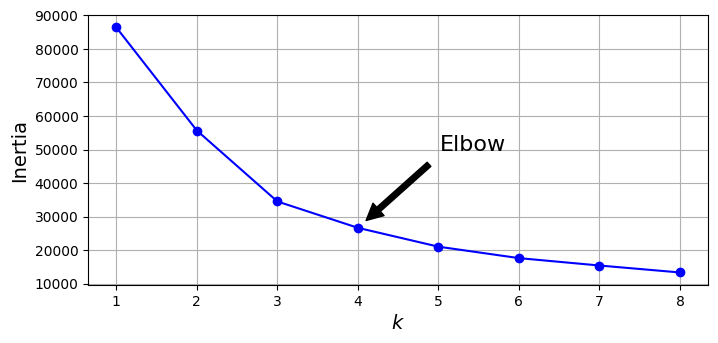

In [41]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 9), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.grid(True)
plt.ylabel("Inertia", fontsize=14)

plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )

#plt.axis([1, 8.5, 0, 1300])

plt.show()

In [42]:
k = 4
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
y_pred = kmeans.fit_predict(X2)
len(y_pred)

43190

In [30]:
kmeans.cluster_centers_

array([[-0.13954681,  1.09954926],
       [ 2.12511901,  0.10884598],
       [ 9.02503148,  0.51427412],
       [-0.22243677, -0.64544116]])

In [31]:
silhouette_scores = [silhouette_score(X2, model.labels_)
                     for model in kmeans_per_k[1:]]

In [32]:
silhouette_scores

[0.4829174236618612,
 0.5120478134194019,
 0.5249281920881675,
 0.43173163820417937,
 0.4392882250548007,
 0.370662457216682,
 0.39065132481032083]

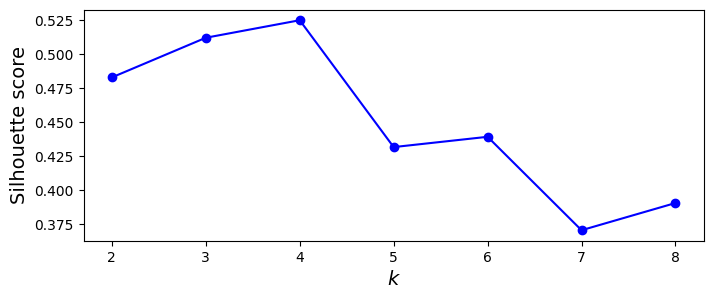

In [43]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 9), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

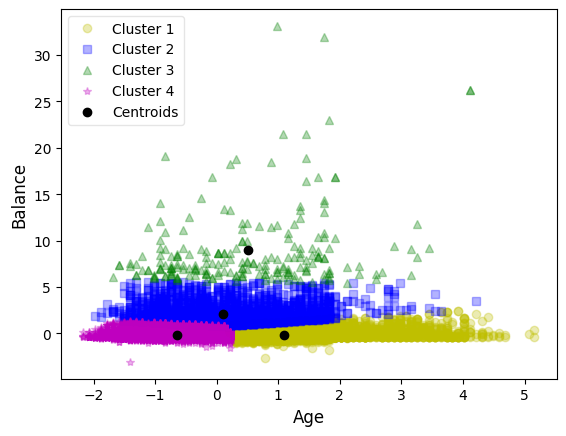

In [44]:
plt.plot(X2[y_pred==0, 1], X2[y_pred==0, 0], "yo", label="Cluster 1", alpha=0.3)
plt.plot(X2[y_pred==1, 1], X2[y_pred==1, 0], "bs", label="Cluster 2", alpha=0.3)
plt.plot(X2[y_pred==2, 1], X2[y_pred==2, 0], "g^", label="Cluster 3", alpha=0.3)
plt.plot(X2[y_pred==3, 1], X2[y_pred==3, 0],"m*", label="Cluster 4", alpha=0.3)
#plt.plot(X2[y_pred==4, 1], X2[y_pred==4, 0], "c.", label="Cluster 5", alpha=0.3)
#plt.plot(X2[y_pred==5, 1], X2[y_pred==5, 0], "r>", label="Cluster 6", alpha=0.3)

plt.plot(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 0], "ko", label="Centroids", alpha=1, ms=6)

plt.xlabel("Age", fontsize=12)
plt.legend(loc="upper left", fancybox=True, framealpha=0.5)
plt.ylabel("Balance", fontsize=12)
plt.show()

## Result
When reading these results it's important to note mean age and balance are 40 and 1362, with their standard deviations are 10.6 and 3044.

This graph helps us visualize all the distinct age/financial demographics of the firm's clients.

**C1**: Middle aged to older people nearing or in retirement with lower to medium balances, these people likely aren't as focused on growing wealth long term as their already a bit older, but still make up a good chunk of the client base.

**C2**: Younger to middle-aged people who are just starting out trying to build out some wealth, they don't have that much money but are likely to have a much longer time horizon for investments due to their younger age, building brand loyalty would be  important for this cluster as many of these clients could go on to be life long clients.

**C3**: These are mostly working class (by age) people who have had some success building wealth and could be considered middle-class, probably the firm's most valuable clients (bread and butter).

**C4**: These people would be considered the very-wealthy top clients, they have had a bit more time to build their wealth and are a bit older then C2, they are highly valued customers but since there are so few of them they are not the most valued client segment, but are the most valued clients.

**Advice for future marketing campaigns:**

Based on the above analysis for the next marketing campaign I would recommend spending a bit less effort advertising to the older people of C1 who don't have as much wealth, and move that manpower towards advertising towards middle-aged people who've got a bit more time and disposable income for investments as those are the people who ultimately become some of the firms higher balanced clients. That's not to say older people should be ignored as they are still a big chunk of the client base, just that they should be focused on less.

Additionally, I would say a small team should be dedicated to advertising to the very wealthy, this firm's only got a shoe in the door with that client segment, but if it could grow that client segment the firm would benefit greatly.

##Additional Analysis

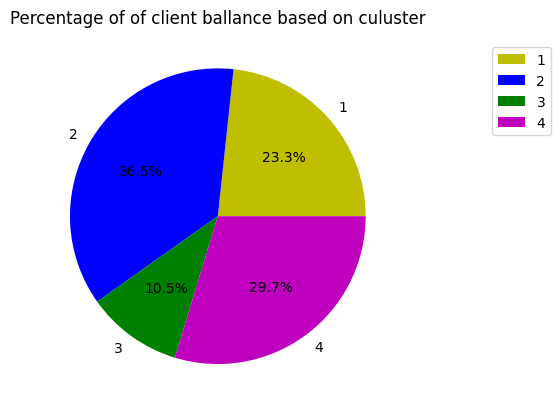

In [36]:
X3 = pd.DataFrame((clean_df[['Balance', 'Age']]))
X3["cluster"] = y_pred

X3 = X3.groupby("cluster").sum()
total = X3[['Balance']].sum()
X3['total'] = (X3['Balance'] / total.values) * 100

X3.total.values

plt.pie(X3.total.values, labels=[1,2,3,4], colors=['y', 'b', 'g', 'm'] ,autopct='%1.1f%%')

plt.title('Percentage of of client ballance based on culuster')
plt.legend(loc="lower right", bbox_to_anchor=(1.42,0.7))

plt.show()


#Second Feature Selection

In [62]:
categorical_cols = ['Balance', 'ContactDuration']
X = clean_df.loc[:, categorical_cols].values
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [63]:
kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(X) for k in range(1,9)]
inertias = [model.inertia_ for model in kmeans_per_k]

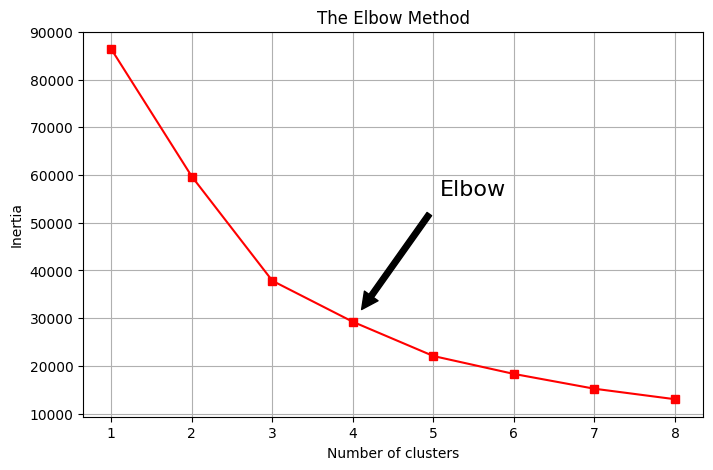

In [64]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 9), inertias, "rs-")
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [65]:
k=4
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
y_pred = kmeans.fit_predict(X)
y_pred

array([3, 0, 0, ..., 1, 1, 0])

In [66]:
kmeans.cluster_centers_

array([[-0.23504907, -0.2900605 ],
       [-0.09643873,  2.17175107],
       [ 7.94345632, -0.02999425],
       [ 1.70285244, -0.16325168]])

In [67]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

In [68]:
silhouette_scores

[0.6276471786947945,
 0.6339399947980999,
 0.5995230541036564,
 0.5212090426951329,
 0.5300723654498428,
 0.4564059710941761,
 0.467057749605149]

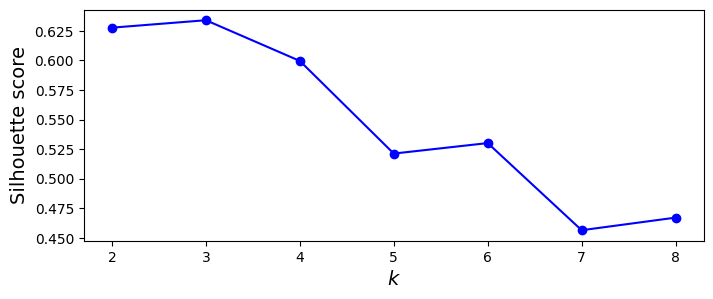

In [69]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 9), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

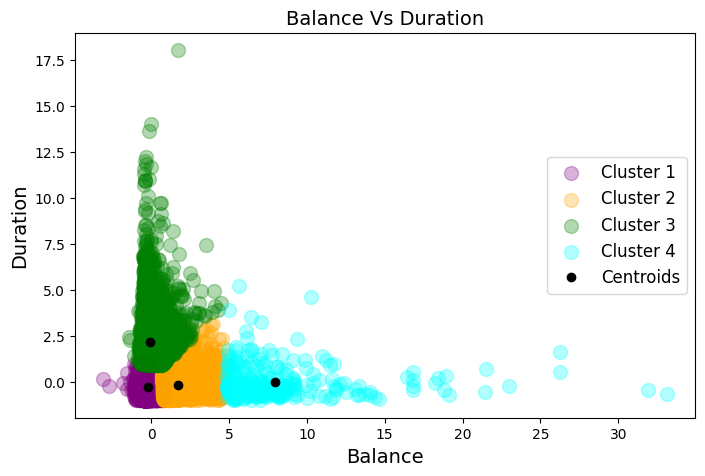

In [53]:
plt.figure(figsize=(8, 5))
plt.scatter(X[y_pred == 0, 0], X[y_pred == 0, 1], s=100, c='purple', marker='o', label='Cluster 1', alpha=0.3)
plt.scatter(X[y_pred == 1, 0], X[y_pred == 1, 1], s=100, c='orange', marker='o', label='Cluster 2', alpha=0.3)
plt.scatter(X[y_pred == 2, 0], X[y_pred == 2, 1], s=100, c='green', marker='o', label='Cluster 3', alpha=0.3)
plt.scatter(X[y_pred == 3, 0], X[y_pred == 3, 1], s=100, c='cyan', marker='o', label='Cluster 4', alpha=0.3)
#plt.scatter(X[y_pred == 4, 0], X[y_pred == 4, 1], s=100, c='red', marker='o',  label='Cluster 5', alpha=0.3)

plt.plot(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], "ko", label="Centroids", alpha=1, ms=6)

plt.title('Balance Vs Duration' , fontsize=14)
plt.xlabel('Balance' , fontsize=14)
plt.ylabel('Duration' , fontsize=14)
#plt.grid('true')
plt.legend(loc ="center right", fontsize=12 )
plt.show()

# Third Feature Selection


In [86]:
'''
categorical_cols = ['Job_admin','Job_blue-collar','Job_entrepreneur',
                    'Job_housemaid','Job_management','Job_retired',
                    'Job_self-employed','Job_services','Job_student',
                    'Job_technician','Job_unemployed','Age','Balance','Credit?']
'''
categorical_cols = ['Age','Balance' , 'Credit?' , 'PersonalLoan']

#categorical_cols = ['CampaignContacts']

X = clean_df.loc[:, categorical_cols].values

scaler = MinMaxScaler().fit(X)


#job_columns = [col for col in new_df.columns if col.startswith('Job_')]

#job_columns

In [87]:
X = scaler.transform(X)
X

array([[0.20779221, 0.13831642, 0.        , 0.        ],
       [0.14285714, 0.08027527, 0.        , 0.        ],
       [0.2987013 , 0.07295771, 0.        , 0.        ],
       ...,
       [0.7012987 , 0.12468905, 0.        , 0.        ],
       [0.50649351, 0.07886805, 0.        , 0.        ],
       [0.24675325, 0.09977666, 0.        , 0.        ]])

In [92]:
kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(X) for k in range(1,9)]
inertias = [model.inertia_ for model in kmeans_per_k]

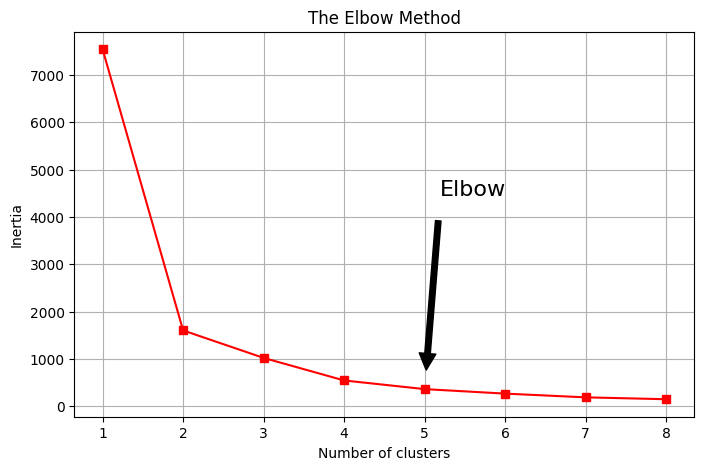

In [93]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 9), inertias, "rs-")
plt.annotate('Elbow',
             xy=(5, inertias[4]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [95]:
k=5
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
y_pred = kmeans.fit_predict(X)
y_pred


array([2, 2, 2, ..., 0, 0, 2])

In [96]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

In [97]:
silhouette_scores

[0.8227904034390955,
 0.8383724097020163,
 0.6356188860687735,
 0.6429420239350295,
 0.5799267932927112,
 0.5464930846891146,
 0.501605335120335]

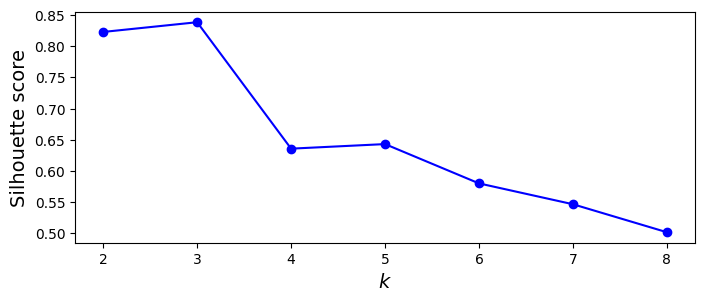

In [98]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 9), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

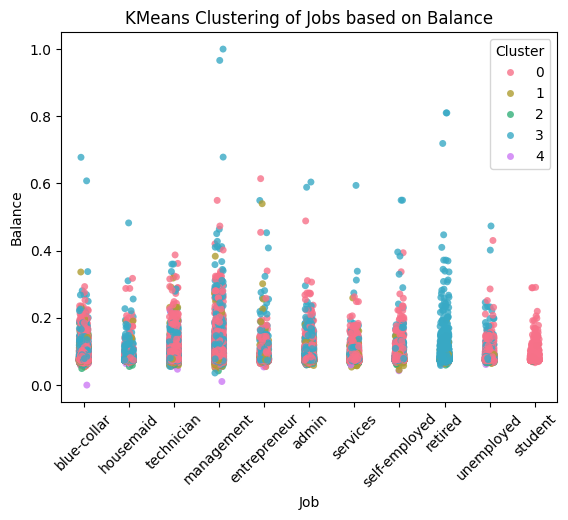

0    22723
3    12869
1     6816
2      491
4      291
Name: Cluster, dtype: int64


In [60]:
'''
categorical_cols = ['Job_admin','Job_blue-collar','Job_entrepreneur',
                    'Job_housemaid','Job_management','Job_retired',
                    'Job_self-employed','Job_services','Job_student',
                    'Job_technician','Job_unemployed', 'Age','Balance','Credit?'] #,'Age','Balance
'''

categorical_cols = ['Age','Balance' , 'Credit?' , 'PersonalLoan']

feacture_four_df = clean_df.loc[:, categorical_cols]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

feacture_four_df['Age'] = scaler.fit_transform(feacture_four_df[['Age']])
feacture_four_df['Balance'] = scaler.fit_transform(feacture_four_df[['Balance']])
feacture_four_df['Credit?'] = scaler.fit_transform(feacture_four_df[['Credit?']])
feacture_four_df['PersonalLoan'] = scaler.fit_transform(feacture_four_df[['PersonalLoan']])

# Perform KMeans clustering
kmeans = KMeans(n_clusters=5, n_init=10,random_state=42)
feacture_four_df['Cluster'] = kmeans.fit_predict(feacture_four_df)


#display(test_df)
# Define a custom color palette with 7 distinct colors
custom_palette = sns.color_palette("husl", 5)

# Visualize the clusters using seaborn
sns.stripplot(data=feacture_four_df, x=jobs, y='Balance', hue='Cluster',palette=custom_palette,alpha=0.8)
# Rotate x-axis labels
plt.xticks(rotation=45)

plt.title('KMeans Clustering of Jobs based on Balance')
plt.show()

print(feacture_four_df['Cluster'].value_counts())


In [61]:
feacture_four_df[(feacture_four_df['Cluster'] == 0)].describe()

,Age,Balance,Credit?,PersonalLoan,Cluster
count,22723.000000,22723.000000,22723.0,22723.0,22723.0
mean,0.209450,0.084641,0.0,0.0,0.0
std,0.065655,0.024156,0.0,0.0,0.0
min,0.000000,0.055699,0.0,0.0,0.0
25%,0.168831,0.073611,0.0,0.0,0.0
50%,0.207792,0.076825,0.0,0.0,0.0
75%,0.259740,0.085119,0.0,0.0,0.0
max,0.324675,0.614348,0.0,0.0,0.0


In [62]:
feacture_four_df[(feacture_four_df['Cluster'] == 1)].describe()

,Age,Balance,Credit?,PersonalLoan,Cluster
count,6816.000000,6816.000000,6816.0,6816.0,6816.0
mean,0.292924,0.080210,0.0,1.0,1.0
std,0.125487,0.017379,0.0,0.0,0.0
min,0.025974,0.045040,0.0,1.0,1.0
25%,0.181818,0.072876,0.0,1.0,1.0
50%,0.272727,0.075377,0.0,1.0,1.0
75%,0.389610,0.081061,0.0,1.0,1.0
max,0.701299,0.539811,0.0,1.0,1.0


In [63]:
feacture_four_df[(feacture_four_df['Cluster'] == 2)].describe()

,Age,Balance,Credit?,PersonalLoan,Cluster
count,491.000000,491.000000,491.0,491.0,491.0
mean,0.276615,0.071747,1.0,0.0,2.0
std,0.118010,0.005161,0.0,0.0,0.0
min,0.038961,0.042189,1.0,0.0,2.0
25%,0.181818,0.070043,1.0,0.0,2.0
50%,0.259740,0.072776,1.0,0.0,2.0
75%,0.363636,0.072962,1.0,0.0,2.0
max,0.688312,0.120458,1.0,0.0,2.0


In [64]:
feacture_four_df[(feacture_four_df['Cluster'] == 3)].describe()

,Age,Balance,Credit?,PersonalLoan,Cluster
count,12869.000000,12869.000000,12869.0,12869.0,12869.0
mean,0.450202,0.089312,0.0,0.0,3.0
std,0.093151,0.036386,0.0,0.0,0.0
min,0.324675,0.035970,0.0,0.0,3.0
25%,0.376623,0.074020,0.0,0.0,3.0
50%,0.428571,0.078614,0.0,0.0,3.0
75%,0.506494,0.090979,0.0,0.0,3.0
max,1.000000,1.000000,0.0,0.0,3.0


In [65]:
feacture_four_df[(feacture_four_df['Cluster'] == 4)].describe()

,Age,Balance,Credit?,PersonalLoan,Cluster
count,291.000000,291.000000,291.0,291.0,291.0
mean,0.283840,0.071297,1.0,1.0,4.0
std,0.127397,0.012003,0.0,0.0,0.0
min,0.038961,0.000000,1.0,1.0,4.0
25%,0.181818,0.069353,1.0,1.0,4.0
50%,0.272727,0.072667,1.0,1.0,4.0
75%,0.376623,0.072899,1.0,1.0,4.0
max,0.545455,0.222477,1.0,1.0,4.0


# Fourth Feature Selection

In [51]:
def cluster_coutcome(value):

  categorical_cols = ['Age','ContactDuration','Balance', 'Coutcome']

  test_df = clean_df.loc[:, categorical_cols]

  test_df = test_df[(test_df['Coutcome'] == value)]

  scaler = MinMaxScaler()

  test_df['Age'] = scaler.fit_transform(test_df[['Age']])
  test_df['ContactDuration'] = scaler.fit_transform(test_df[['ContactDuration']])
  test_df['Balance'] = scaler.fit_transform(test_df[['Balance']])
  test_df['Coutcome'] = scaler.fit_transform(test_df[['Coutcome']])


  # Perform KMeans clustering
  kmeans = KMeans(n_clusters=5, n_init=10,random_state=42)
  test_df['Cluster'] = kmeans.fit_predict(test_df)

  return test_df


combined_total_Coutcome_yes = cluster_coutcome(1)['Cluster'].value_counts().sort_index().values
combined_total_Coutcome_no = cluster_coutcome(0)['Cluster'].value_counts().sort_index().values

combined_cluster_result = [[x, y] for x, y in zip(combined_total_Coutcome_yes, combined_total_Coutcome_no)]

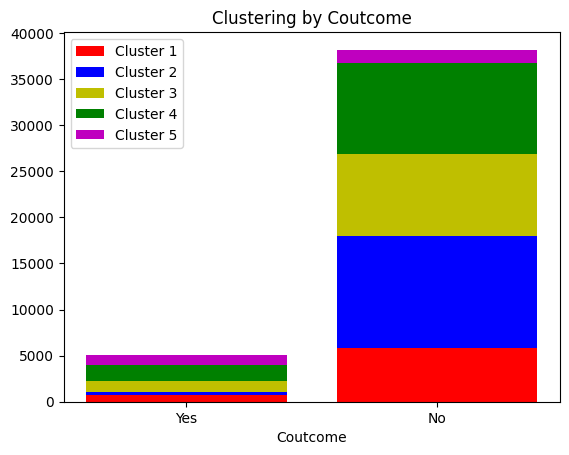

In [57]:
# create data
x = ['Yes', 'No']
y1 = np.array(combined_cluster_result[0])
y2 = np.array(combined_cluster_result[1])
y3 = np.array(combined_cluster_result[2])
y4 = np.array(combined_cluster_result[3])
y5 = np.array(combined_cluster_result[4])

# plot bars in stack manner
plt.bar(x, y1, color='r')
plt.bar(x, y2, bottom=y1, color='b')
plt.bar(x, y3, bottom=y1+y2, color='y')
plt.bar(x, y4, bottom=y1+y2+y3, color='g')
plt.bar(x, y5, bottom=y1+y2+y3+y4, color='m')


plt.xlabel("Coutcome")
plt.legend(["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4","Cluster 5"])
plt.title("Clustering by Coutcome")
plt.show()

In [73]:

categorical_cols = ['Age','ContactDuration','Balance', 'Coutcome']

test_df = clean_df.loc[:, categorical_cols]


scaler = MinMaxScaler()

test_df['Age'] = scaler.fit_transform(test_df[['Age']])
test_df['ContactDuration'] = scaler.fit_transform(test_df[['ContactDuration']])
test_df['Balance'] = scaler.fit_transform(test_df[['Balance']])
test_df['Coutcome'] = scaler.fit_transform(test_df[['Coutcome']])


# Perform KMeans clustering
kmeans = KMeans(n_clusters=5,n_init=10, random_state=42)
test_df['Cluster'] = kmeans.fit_predict(test_df)
y_pred = kmeans.fit_predict(test_df)
X2 = test_df.values

In [74]:
kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(X2) for k in range(1,9)]
inertias = [model.inertia_ for model in kmeans_per_k]

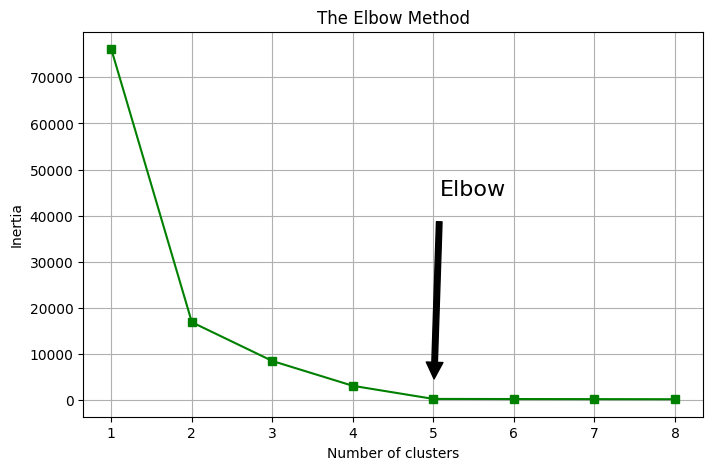

In [81]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 9), inertias, "gs-")
plt.annotate('Elbow',
             xy=(5, inertias[4]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [78]:
silhouette_scores = [silhouette_score(X2, model.labels_)
                     for model in kmeans_per_k[1:]]

In [79]:
silhouette_scores

[0.7420033826086243,
 0.7626133924637231,
 0.8685198049969101,
 0.9238271094438637,
 0.8169963338174137,
 0.7067682296032787,
 0.44463549455011214]

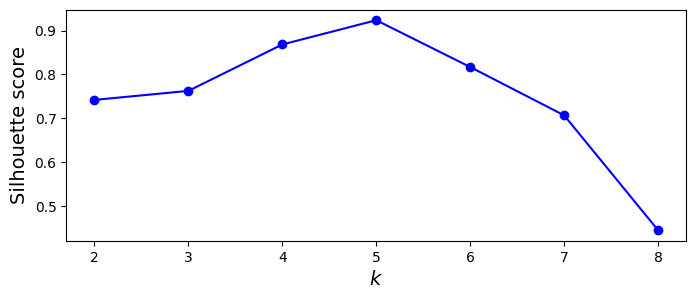

In [80]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 9), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

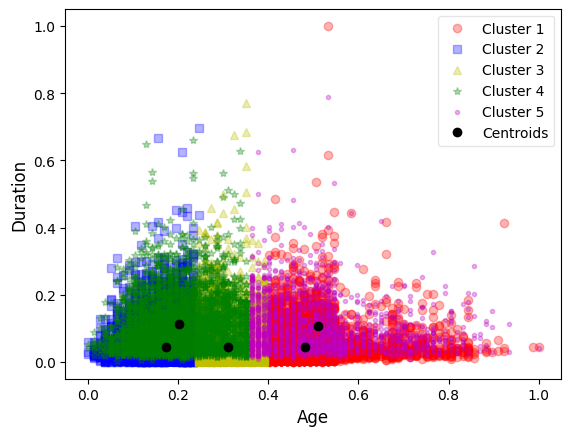

In [54]:
plt.plot(X2[y_pred==0, 0], X2[y_pred==0, 1], "ro", label="Cluster 1", alpha=0.3)
plt.plot(X2[y_pred==1, 0], X2[y_pred==1, 1], "bs", label="Cluster 2", alpha=0.3)
plt.plot(X2[y_pred==2, 0], X2[y_pred==2, 1], "y^", label="Cluster 3", alpha=0.3)
plt.plot(X2[y_pred==3, 0], X2[y_pred==3, 1],"g*", label="Cluster 4", alpha=0.3)
plt.plot(X2[y_pred==4, 0], X2[y_pred==4, 1], "m.", label="Cluster 5", alpha=0.3)

plt.plot(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], "ko", label="Centroids", alpha=1, ms=6)

plt.xlabel("Age", fontsize=12)
plt.legend(loc="upper right", fancybox=True, framealpha=0.5)
plt.ylabel("Duration", fontsize=12)
plt.show()

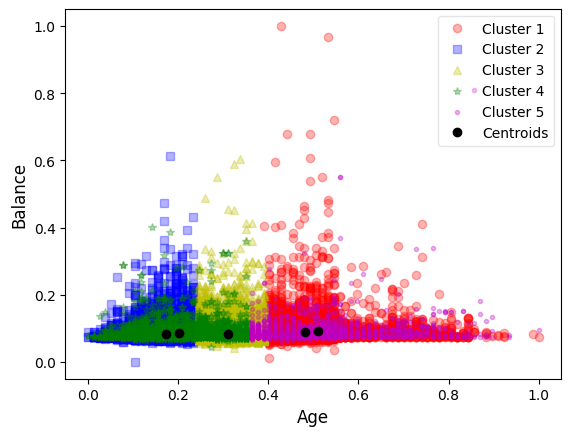

In [49]:
plt.plot(X2[y_pred==0, 0], X2[y_pred==0, 2], "ro", label="Cluster 1", alpha=0.3)
plt.plot(X2[y_pred==1, 0], X2[y_pred==1, 2], "bs", label="Cluster 2", alpha=0.3)
plt.plot(X2[y_pred==2, 0], X2[y_pred==2, 2], "y^", label="Cluster 3", alpha=0.3)
plt.plot(X2[y_pred==3, 0], X2[y_pred==3, 2],"g*", label="Cluster 4", alpha=0.3)
plt.plot(X2[y_pred==4, 0], X2[y_pred==4, 2], "m.", label="Cluster 5", alpha=0.3)

plt.plot(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 2], "ko", label="Centroids", alpha=1, ms=6)

plt.xlabel("Age", fontsize=12)
plt.legend(loc="upper right", fancybox=True, framealpha=0.5)
plt.ylabel("Balance", fontsize=12)
plt.show()